# Continuous Bernoulli 

In [1]:
# Libraries 
import os
import torch
import argparse
import torchvision
import numpy as np
from glob import glob
import torch.utils.data
import matplotlib as mpl
from torch import nn, optim
import matplotlib.pyplot as plt
from torch.nn import functional as F
from matplotlib import cm as color_map
from torchvision.utils import save_image
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

%matplotlib inline

#Set reproducibility seeed
torch.manual_seed(1)

## Load and Preprocess MNIST Dataset 

In [2]:
BATCH_SIZE = 128 # Not especified in paper

## MNIST Preprocessing as described in Appendix 4

# Add custom transformation that adds uniform [0,1] noise 
# to the integer pixel values between 0 and 255 and then 
# divide by 256, to obtain values in [0,1]
class AddNoiseToTensor(object):

    def __call__(self, pic):
        
        img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
        nchannel = len(pic.mode)
        img = img.view(pic.size[1], pic.size[0], nchannel)
        img = img.transpose(0, 1).transpose(0, 2).contiguous()
        tensor = img.float()
        return ( tensor + torch.rand(tensor.size())).div(256.)

## MNIST dataset
mnist_train_loader = torch.utils.data.DataLoader(
                            datasets.MNIST('../../data', train=True, download=True,
                            transform = AddNoiseToTensor()),
                            batch_size = BATCH_SIZE, shuffle = True)

mnist_test_loader = torch.utils.data.DataLoader(
                            datasets.MNIST('../../data', train=False, 
                            transform = AddNoiseToTensor()),
                            batch_size = BATCH_SIZE, shuffle = True)

    9     3     0     1     2     4     6     8     1     1     2     3     0     7     0     0


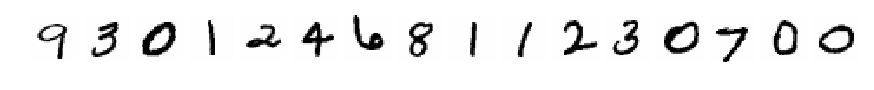

In [3]:
# Visualize dataset 
dataiter = iter(mnist_train_loader)
mnist_images, mnist_labels = dataiter.next()

def imshow(img):
    npimg = 1 - img.numpy() # White background
    plt.figure(figsize = (15, 15))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)), 
               interpolation = 'nearest')

# Display images with labels
imshow(torchvision.utils.make_grid(mnist_images[:16], 16 ))
print(' '.join('%5s' % str(mnist_labels[j].item()) for j in range(16)))

## Variational Autoencoder

In [24]:
# VAE model 

## Architectured Based on Appendix by Authors
## https://arxiv.org/src/1907.06845v4/anc/cont_bern_aux.pdf

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # Encoder layers
        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc21 = nn.Linear(500, 20)
        self.fc22 = nn.Linear(500, 20)
        
        # Decoder layers
        self.fc3 = nn.Linear(20, 500)
        self.fc4 = nn.Linear(500, 500)
        self.fc5 = nn.Linear(500, 784)
        
        # Dropout Layers
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)
        self.dropout3 = nn.Dropout(0.1)
        self.dropout4 = nn.Dropout(0.1)

    def encode(self, x):
        #Recognition function
        h1 = F.relu(self.fc1(x))
        h1 = self.dropout1(h1)
        h2 = F.relu(self.fc2(h1))
        h2 = self.dropout2(h2)
        return self.fc21(h2), F.softplus(self.fc22(h2)) 

    def reparameterize(self, mu, std):
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        #Likelihood function
        h3 = F.relu(self.fc3(z))
        h3 = self.dropout3(h3)
        h4 = F.relu(self.fc4(h3))
        h4 = self.dropout4(h4)
        return torch.sigmoid( self.fc5(h4) ) # Gaussian mean

    def forward(self, x):
        mu, std = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, std)
        # Return decoding, mean and logvar
        return self.decode(z), mu, 2.*torch.log(std) 
    
# Loss function
def loss_vae(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

## Train VAE on MNIST

In [29]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

def train(model, optimizer, epochs, 
          train_loader, loss_function, 
          filename = 'model', log_interval = 1000):
    
    model.train()
    for epoch in range(1, epochs + 1):
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    loss.item() / len(data)))

        print('====> Epoch: {} Average loss: {:.4f}'.format(
              epoch, train_loss / len(train_loader.dataset)))
        
    # Store model
    torch.save(model.state_dict(), filename + '_epoch_' + str(epochs) + '.pt' )

In [30]:
# Train model
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer, 1, mnist_train_loader, loss_vae)

Train Epoch: 1 [0/60000 (0%)]	Loss: 545.832825
====> Epoch: 1 Average loss: 186.2553


In [7]:
## Generate samples from pre-trained model

# Load Pre-trained model
#model = VAE().to(device)
#model.load_state_dict(torch.load('model_epoch_100.pt'))

model.eval()
with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = model.decode(sample).cpu()
        #imshow(torchvision.utils.make_grid(sample[:16], 16 ))
        save_image(sample.view(64, 1, 28, 28),
                   'sample_' + str(1) + '.png')

## Continuous Bernoulli Distribution

In [31]:
def C( x ):
    return (2. * np.arctanh(1. - 2.*x))/(1. - 2.*x) 
    
def logC( x ):
    # Numerically stable implementation
    if abs(x - 0.5) < 1e-3:
        # Taylor Approximation around 0.5
        value = np.log(2.)
        taylor = 1; nu = 1. - 2. * x; e = 1; k = nu**2
        for i in range(1, 10): 
            e *= k; taylor += e / (2. * i + 1) 
        return value + np.log( taylor )
    return np.log( C(x) )

In [32]:
# Testing numerical inestability
l = 0.499
print('At lambda = 0.499:')
print( logC(l))
print( np.log(C(l)))

l = 0.5-1e-17
print('\n At lambda ~ 0.5:')
print( logC(l))
print( np.log(C(l)) ) 

At lambda = 0.499:
0.6931485138955896
0.6931485138955896

 At lambda ~ 0.5:
0.6931471805599453
nan


/home/alfredo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


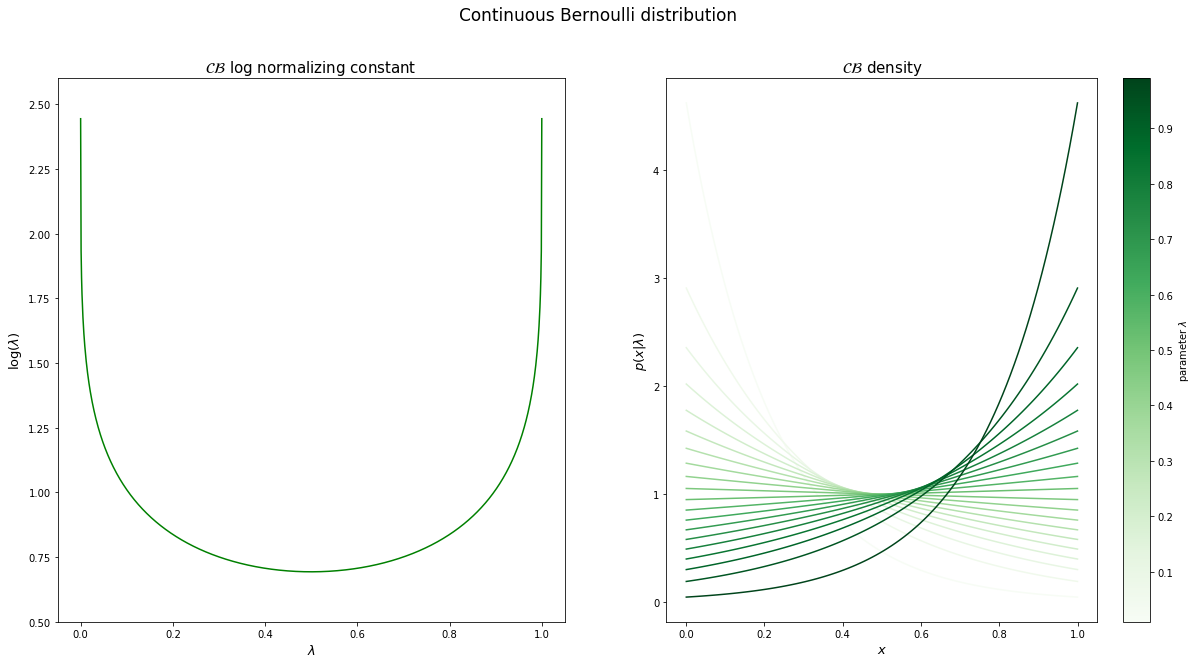

In [33]:
# Make plots 
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, figsize = (20, 10 ))

ax = axs[0]
# Plot Continuous Bernoulli Log Normalizing Constant 
x = np.linspace(0.00001,0.99999,1000)
y = [ logC(i) for i in x ]

ax.set_title('$\mathcal{C}\mathcal{B}$ log normalizing constant', 
           fontsize = 15)
ax.set_ylim(0.50, 2.6)
ax.plot(x, y, color = 'green' , label = 'Taylor Approximation') 
ax.set_ylabel('$\log(\lambda)$', fontsize = 13)
ax.set_xlabel('$\lambda$', fontsize = 13)


ax = axs[1]

x = np.linspace(0.001,0.999,100)
l = np.linspace(0.01,0.99,20)
y = np.asarray( [ [ np.exp(logC(i))*np.power(i,j)*np.power(1-i,1-j) for j in x] for i in l] )

number_of_plots = len(l)
color_map_name = 'Greens'
my_map = color_map.get_cmap(color_map_name)
colors = my_map(np.linspace(0, 1, number_of_plots, endpoint=True))

norm = mpl.colors.Normalize(vmin=l[0], vmax=l[-1])
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=color_map_name)
cmap.set_array([])

for i in range(len(l)):
    ax.plot(x, y[i,:], color = colors[i]) 

ax.set_title('$\mathcal{C}\mathcal{B}$ density', 
           fontsize = 15)

ax.set_ylabel('$p(x |\lambda)$', fontsize = 13)
ax.set_xlabel('$x$', fontsize = 13)

fig.colorbar(cmap, ticks=np.linspace(0, 1, 11), 
             shrink=1.0, fraction=0.1, pad=0.05 , label = 'parameter $\lambda$')


fig.suptitle('Continuous Bernoulli distribution', fontsize = 17)

plt.show()

## Continuous Bernoulli VAE

In [34]:
def sumlogC( x , eps = 1e-5):
    '''
    Numerically stable implementation of 
    sum of logarithm of Continous Bernoulli
    constant C, using Taylor 2nd degree approximation
        
    Parameter
    ----------
    x : Tensor of dimensions (batch_size, dim)
        x takes values in (0,1)
    ''' 
    x = torch.clamp(x, eps, 1.-eps) 
    mask = torch.abs(x - 0.5).ge(eps)
    far = torch.masked_select(x, mask)
    close = torch.masked_select(x, ~mask)
    far_values =  torch.log( (torch.log(1. - far) - torch.log(far)).div(1. - 2. * far) )
    close_values = torch.log(torch.tensor((2.))) + torch.log(1. + torch.pow( 1. - 2. * close, 2)/3. )
    return far_values.sum() + close_values.sum()

In [35]:
# Test numerical stability of function 
a = torch.rand(size = (32, 64))
print(a)
print(sumlogC(a))
print(np.log(C(a)).sum())

tensor([[0.9491, 0.4672, 0.6760,  ..., 0.7568, 0.0613, 0.1642],
        [0.7962, 0.0930, 0.8384,  ..., 0.8286, 0.2767, 0.7541],
        [0.7412, 0.4127, 0.2574,  ..., 0.5692, 0.3860, 0.1503],
        ...,
        [0.9014, 0.9868, 0.7091,  ..., 0.7792, 0.5065, 0.5195],
        [0.3264, 0.3887, 0.3075,  ..., 0.7810, 0.2690, 0.6852],
        [0.9216, 0.2519, 0.2667,  ..., 0.6885, 0.3538, 0.7251]])
tensor(1777.4165)
tensor(1777.4541)


In [36]:
# Loss function for continuous bernoulli vae
def loss_cbvae(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    LOGC = sumlogC(recon_x)
    print('BCE: ', BCE)
    print('KLD: ', KLD)
    print('LOGC: ', LOGC)
    return BCE + KLD + LOGC

In [37]:
# Train model
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer, 10, mnist_train_loader, loss_cbvae)

BCE:  tensor(69586.8672, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
KLD:  tensor(284.2594, device='cuda:0', grad_fn=<MulBackward0>)
LOGC:  tensor(69616.0234, device='cuda:0', grad_fn=<AddBackward0>)
Train Epoch: 1 [0/60000 (0%)]	Loss: 1089.743408
BCE:  tensor(67420.6562, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
KLD:  tensor(203.1831, device='cuda:0', grad_fn=<MulBackward0>)
LOGC:  tensor(69653.6641, device='cuda:0', grad_fn=<AddBackward0>)
BCE:  tensor(64344.0195, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
KLD:  tensor(133.4980, device='cuda:0', grad_fn=<MulBackward0>)
LOGC:  tensor(69848.4688, device='cuda:0', grad_fn=<AddBackward0>)
BCE:  tensor(59185.6406, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
KLD:  tensor(123.5207, device='cuda:0', grad_fn=<MulBackward0>)
LOGC:  tensor(70553.6562, device='cuda:0', grad_fn=<AddBackward0>)
BCE:  tensor(50492.6641, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
KLD:  tensor(348.9550, devic

KLD:  tensor(107.5522, device='cuda:0', grad_fn=<MulBackward0>)
LOGC:  tensor(78898.8516, device='cuda:0', grad_fn=<AddBackward0>)
BCE:  tensor(40248.5078, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
KLD:  tensor(123.8604, device='cuda:0', grad_fn=<MulBackward0>)
LOGC:  tensor(78554.4219, device='cuda:0', grad_fn=<AddBackward0>)
BCE:  tensor(40049.6875, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
KLD:  tensor(105.4881, device='cuda:0', grad_fn=<MulBackward0>)
LOGC:  tensor(78395.1094, device='cuda:0', grad_fn=<AddBackward0>)
BCE:  tensor(39674.9570, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
KLD:  tensor(95.6434, device='cuda:0', grad_fn=<MulBackward0>)
LOGC:  tensor(78830.2500, device='cuda:0', grad_fn=<AddBackward0>)
BCE:  tensor(38770.4492, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
KLD:  tensor(76.1245, device='cuda:0', grad_fn=<MulBackward0>)
LOGC:  tensor(79588.7422, device='cuda:0', grad_fn=<AddBackward0>)
BCE:  tensor(38423.9531, de

KeyboardInterrupt: 

In [263]:
## Generate samples from trained model
with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = model.decode(sample).cpu()
        #imshow(torchvision.utils.make_grid(sample[:16], 16 ))
        save_image(sample.view(64, 1, 28, 28),
                   'sample_' + str(10) + '.png')

## Warping Transform

In [20]:
def warp(gamma, x):
    '''
    Warping transform
    
    Parameter
    ----------
    gamma : float 
        warping constant between -0.5 and 0.5
    
    x : Tensor of dimensions (batch_size, dim)
        x takes values in (0,1)
    ''' 
    if gamma == -0.5:
        return x.ge(0.5).float()
    elif gamma > -0.5 and gamma < 0:
        return torch.clamp( ( x + gamma ).div(1. + 2. * gamma ), 0., 1.)
    elif gamma >= 0 and gamma <= 0.5:
        return gamma + ( 1. - 2. * gamma) * x 

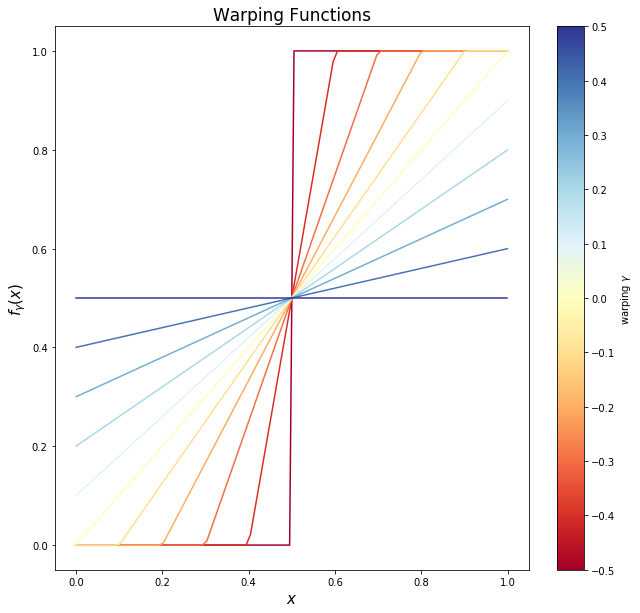

In [21]:
# Visualize warping function behavior 
x = np.linspace(0.001,0.999,100)
l = np.linspace(-0.5,0.5,11)
y = np.asarray( [ warp(i, torch.Tensor(x)).numpy() for i in l] )

plt.figure(figsize =  (10, 10))

number_of_plots = len(l)
color_map_name = 'RdYlBu'
my_map = color_map.get_cmap(color_map_name)
colors = my_map(np.linspace(0, 1, number_of_plots, endpoint=True))

norm = mpl.colors.Normalize(vmin=l[0], vmax=l[-1])
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=color_map_name)
cmap.set_array([])

for i in range(len(l)):
    plt.plot(x, y[i], color = colors[i]) 

plt.title('Warping Functions', 
           fontsize = 17)

plt.ylabel('$f_{\gamma}(x)$', fontsize = 15)
plt.xlabel('$x$', fontsize = 15)
plt.ylim(-0.05, 1.05)

plt.colorbar(cmap, ticks=np.linspace(-0.5, 0.5, 11), 
             shrink=1.0, fraction=0.1, pad=0.05 , 
             label = 'warping $\gamma$')

plt.show()

In [22]:
# Warping Transformation
class Warping(object):
    
    def __init__(self, parameter):
        self.parameter = parameter
            
    def __call__(self, pic):
        return warp(self.parameter, pic)

In [23]:
## Visualize warping MNIST
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import FloatSlider
import ipywidgets as widgets

dataiter = iter(mnist_train_loader)
mnist_images, mnist_labels = dataiter.next()

def plot_result( warp_ ):
    
    z = torch.from_numpy(np.asarray([warp_])).view(1,-1)
    z = z.type(torch.FloatTensor)
    fig, ax = plt.subplots(nrows=1, ncols = 1 , figsize=(10,5 ) )
    #Plot decoded images
    img =  torchvision.utils.make_grid(mnist_images[:4], 4 ) 
    img = warp(warp_, img)
    npimg = 1 - img.detach().numpy() # White background
    plt.axis('off')
    plt.title('Warped Image', fontsize = 20 )
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation = 'nearest')
    

interact(plot_result , warp_ = FloatSlider(min=-0.5, max=0.5, step=0.1)  )

interactive(children=(FloatSlider(value=0.0, description='warp_', max=0.5, min=-0.5), Output()), _dom_classes=…

<function __main__.plot_result(warp_)>